<a href="https://colab.research.google.com/github/andreYoo/Time-series-analysis-anomaly-detection/blob/main/ARIMA_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#!pip install ~~

1. 모듈 불러오기

In [35]:
#!pip install pmdarima

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib 

plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
#matplotlib inline

import itertools

# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


공공 데이터 (AirPassengers.csv) 활용


1949년~1960년 매달 비행기 탑승객 수에 대한 시계열 데이터


데이터 구조: 144x1


In [36]:
data = pd.read_csv('./drive/MyDrive/study/AirPassengers.csv')
data = data.rename(columns={'Month':'month', '#Passengers':'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


ARIMA procedure


1. Data preprocessing

2. Model check, 

3. Estimate parameter

4. Diagnisis check

5. Use model to Forecast



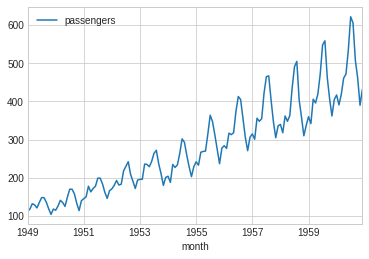

In [37]:
fig = data.plot()

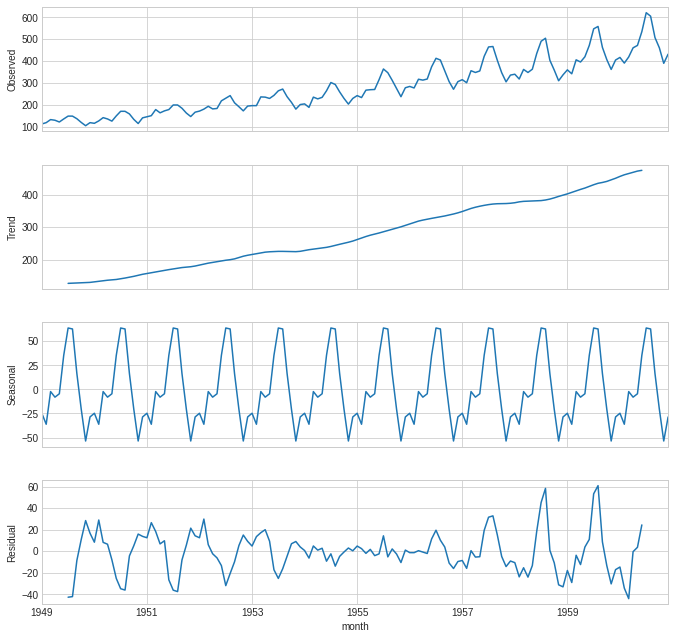

In [38]:
# 시계열 분해(계절성 분해)
# 덧셈 방식을 채택했으며 고전적 분해인것 같다.
decomposition = sm.tsa.seasonal_decompose(data['passengers'], model = 'additive')
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [39]:
train_data, test_data = train_test_split(data,test_size=0.2, shuffle=False)

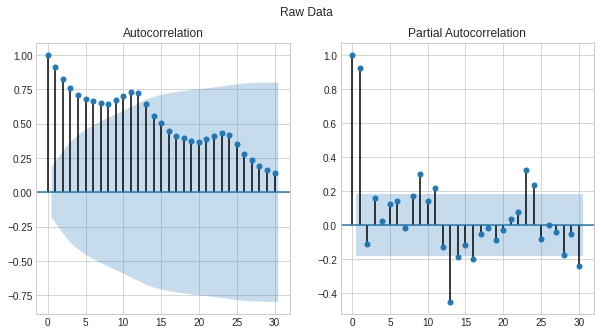

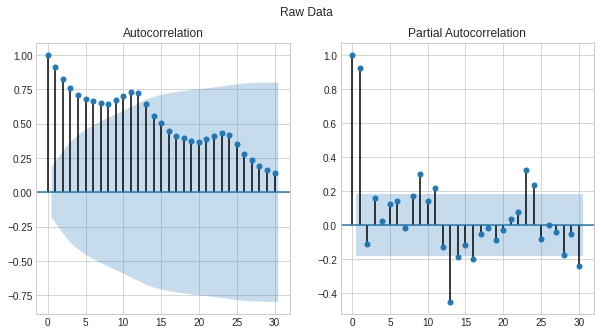

In [40]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(),lags=30,ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),lags=30,ax=ax[1])


Signal 이 Non-stationary 하기 떄문에 차분 (Differencing) 을 해주어야 한다. 

In [41]:
# 차분
diff_train_data = train_data.copy()
# default 는 lag=1, na 는 제거
diff_train_data = diff_train_data.diff().dropna()
print('Raw data')
print(train_data)
print('differenced data')
print(diff_train_data)

Raw data
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
differenced data
            passengers
month                 
1949-02-01         6.0
1949-03-01        14.0
1949-04-01        -3.0
1949-05-01        -8.0
1949-06-01        14.0
...                ...
1958-03-01        44.0
1958-04-01       -14.0
1958-05-01        15.0
1958-06-01        72.0
1958-07-01        56.0

[114 rows x 1 columns]


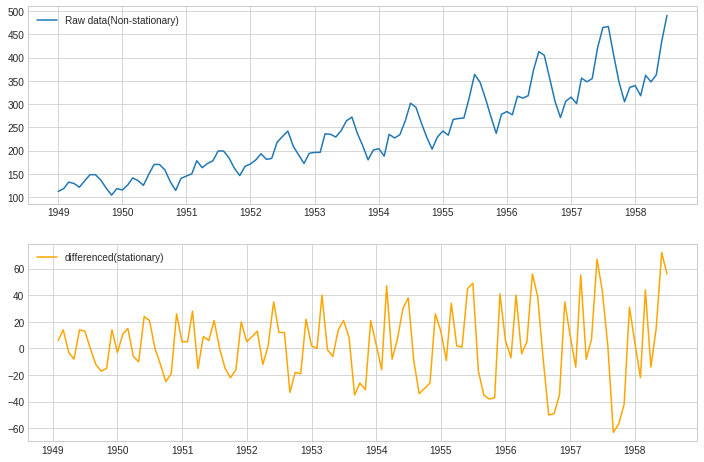

In [42]:
# 차분 데이터 plot

plt.figure(figsize = (12,8))
# 오 이런식으로도 가능하구나. 
# subplot 바로 적용하고 세로2가로1에서 첫번째로 지정한 것
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw data(Non-stationary)'])
plt.subplot(212)
plt.plot(diff_train_data, color= 'orange')
plt.legend(['differenced(stationary)'])

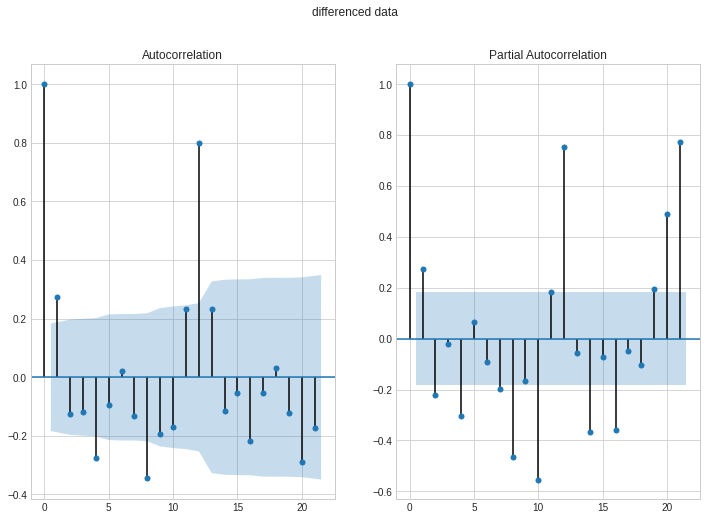

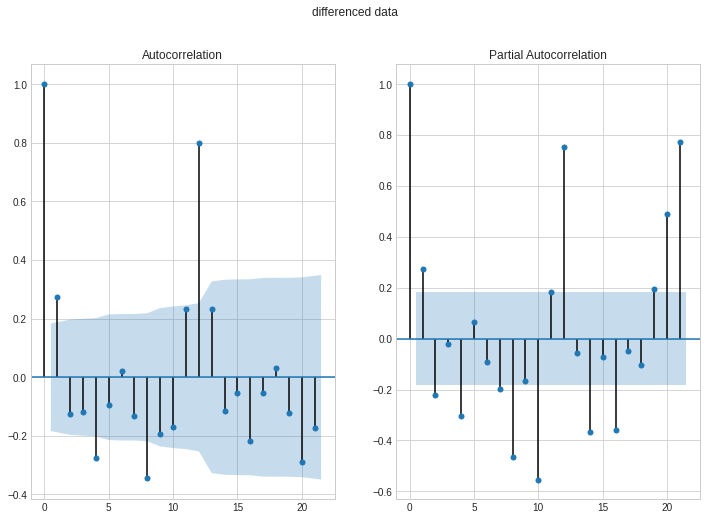

In [43]:
# 차분한 데이터의 ACF, PACF

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('differenced data')

sm.graphics.tsa.plot_acf(diff_train_data, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data, ax = ax[1])

Graphical method를 통해 어떤 model 을 진행할것인지 산정해야 한다.


지수적으로 감소하고 Sin 함수의 형태를 띄기 떄문에 AR 모델을 진행해보자.

별도로 감소하는 부분을 찾기 힘들어 p값은 1로 설정





In [44]:
model = ARIMA(train_data, order = (1,1,0))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Mon, 24 Jan 2022   AIC                           1069.440
Time:                        04:20:04   BIC                           1077.649
Sample:                    02-01-1949   HQIC                          1072.771
                         - 07-01-1958                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.5123      3.329      1.055      0.294      -3.012      10.036
ar.L1.D.passengers     0.2803      0.091      3.077      0.003       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

In [45]:
# parameter search

p = range(0,3)
d = range(1,2)
q = range(0,3)

# itertools 는 이터레이션을 도와주는 라이브러리로,
# itertools.product 는 인수로 들어간 것들의 모든 조합을 반환한다.
pdq = list(itertools.product(p,d,q))
print(pdq)

aic = []
for i in pdq:
    model = ARIMA(train_data, order = i)
    model_fit = model.fit()
    print('ARIMA: {0} >> AIC : {1}'.format(i, round(model_fit.aic,2)))
    aic.append(round(model_fit.aic,2))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_m

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
ARIMA: (0, 1, 0) >> AIC : 1076.52
ARIMA: (0, 1, 1) >> AIC : 1064.62
ARIMA: (0, 1, 2) >> AIC : 1061.08
ARIMA: (1, 1, 0) >> AIC : 1069.44
ARIMA: (1, 1, 1) >> AIC : 1058.83
ARIMA: (1, 1, 2) >> AIC : 1046.05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:


ARIMA: (2, 1, 0) >> AIC : 1066.2
ARIMA: (2, 1, 1) >> AIC : 1045.66


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:


ARIMA: (2, 1, 2) >> AIC : 1047.19


In [46]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal[0]

((2, 1, 1), 1045.66)

In [47]:
model_opt = ARIMA(train_data, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Mon, 24 Jan 2022   AIC                           1045.660
Time:                        04:20:06   BIC                           1059.341
Sample:                    02-01-1949   HQIC                          1051.212
                         - 07-01-1958                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5600      0.163     15.754      0.000       2.241       2.878
ar.L1.D.passengers     1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.passengers    -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.passengers    -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

Use model to Forecast - ARIMA

In [48]:
pred = model_opt_fit.forecast(len(test_data))
# forecast라는 메서드를 많이 쓴다고 하며, 들어가는 인수는 이 후로 얼마나 예측할지이다.
# predict 메서드도 존재하며 이는 start와 end index를 집어넣어 값을 도출한다.

# .forecast 는 3개의 array를 튜플로 묶은 데이터를 반환한다. 
# 첫번째 array 는 점예측값이고 두번째는 upper bound, 세번째는 lower bound 이다. 
pred = model_opt_fit.forecast(len(test_data))
pred_value = pred[0]

pred_ub = pred[2][:,0]
pred_lb = pred[2][:,1]
pred_index = list(test_data.index)
r2 = r2_score(test_data, pred_value)

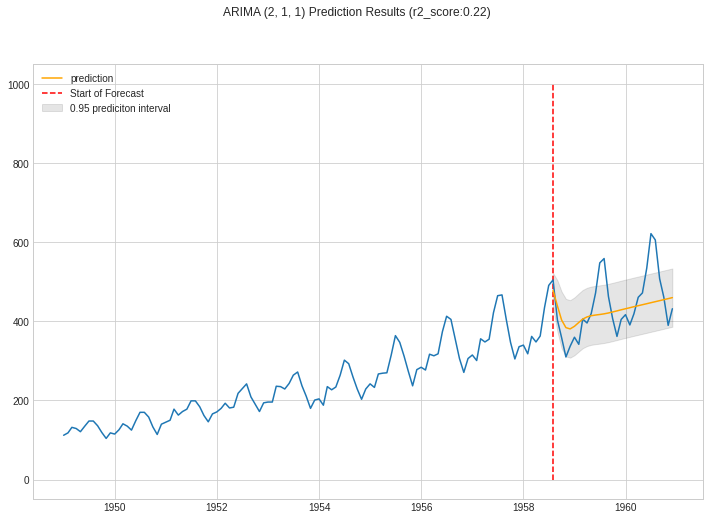

In [49]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(data.index, data.passengers)
# 그냥 날짜 넣으니까 인식몬해서 이렇게 함.
ax.vlines(pd.to_datetime('1958-08-01'), 0, 1000,linestyle = '--', color='r', 
         label='Start of Forecast');
ax.plot(pred_index, pred_value, label = 'prediction',color='orange')
# 요걸로 범위 채우기
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1,
               label='0.95 prediciton interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score:{round(r2,2)})')
plt.show()

Disgnosis check _SARIMA


In [50]:
# 우선 어떤 parameter 를 넣을지 search 해보자

print('Examples of parameter combinations of SARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
s = range(12,13)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print(pdq)

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA parameter : {i} {j} >> AIC: {round(model_fit.aic,2)}')
            params.append((i,j))
            aic.append(round(model_fit.aic,2))
        except:
            continue
            


Examples of parameter combinations of SARIMA...
[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
SARIMA parameter : (0, 1, 0) (0, 1, 0, 12) >> AIC: 757.83
SARIMA parameter : (0, 1, 0) (0, 1, 1, 12) >> AIC: 756.99
SARIMA parameter : (0, 1, 0) (0, 1, 2, 12) >> AIC: 758.83
SARIMA parameter : (0, 1, 0) (1, 1, 0, 12) >> AIC: 756.96
SARIMA parameter : (0, 1, 0) (1, 1, 1, 12) >> AIC: 758.92
SARIMA parameter : (0, 1, 0) (1, 1, 2, 12) >> AIC: 754.42
SARIMA parameter : (0, 1, 0) (2, 1, 0, 12) >> AIC: 758.87
SARIMA parameter : (0, 1, 0) (2, 1, 1, 12) >> AIC: 760.73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (0, 1, 0) (2, 1, 2, 12) >> AIC: 754.91
SARIMA parameter : (0, 1, 1) (0, 1, 0, 12) >> AIC: 756.01
SARIMA parameter : (0, 1, 1) (0, 1, 1, 12) >> AIC: 756.38
SARIMA parameter : (0, 1, 1) (0, 1, 2, 12) >> AIC: 757.65
SARIMA parameter : (0, 1, 1) (1, 1, 0, 12) >> AIC: 756.17
SARIMA parameter : (0, 1, 1) (1, 1, 1, 12) >> AIC: 758.11


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (0, 1, 1) (1, 1, 2, 12) >> AIC: 751.73
SARIMA parameter : (0, 1, 1) (2, 1, 0, 12) >> AIC: 757.99
SARIMA parameter : (0, 1, 1) (2, 1, 1, 12) >> AIC: 753.78
SARIMA parameter : (0, 1, 2) (0, 1, 0, 12) >> AIC: 757.78
SARIMA parameter : (0, 1, 2) (0, 1, 1, 12) >> AIC: 758.04
SARIMA parameter : (0, 1, 2) (0, 1, 2, 12) >> AIC: 759.28
SARIMA parameter : (0, 1, 2) (1, 1, 0, 12) >> AIC: 757.81
SARIMA parameter : (0, 1, 2) (1, 1, 1, 12) >> AIC: 759.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (0, 1, 2) (1, 1, 2, 12) >> AIC: 753.5
SARIMA parameter : (0, 1, 2) (2, 1, 0, 12) >> AIC: 759.64
SARIMA parameter : (0, 1, 2) (2, 1, 1, 12) >> AIC: 755.48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (0, 1, 2) (2, 1, 2, 12) >> AIC: 763.54
SARIMA parameter : (1, 1, 0) (0, 1, 0, 12) >> AIC: 755.5
SARIMA parameter : (1, 1, 0) (0, 1, 1, 12) >> AIC: 755.98
SARIMA parameter : (1, 1, 0) (0, 1, 2, 12) >> AIC: 757.1
SARIMA parameter : (1, 1, 0) (1, 1, 0, 12) >> AIC: 755.75
SARIMA parameter : (1, 1, 0) (1, 1, 1, 12) >> AIC: 757.65
SARIMA parameter : (1, 1, 0) (1, 1, 2, 12) >> AIC: 751.15
SARIMA parameter : (1, 1, 0) (2, 1, 0, 12) >> AIC: 757.45
SARIMA parameter : (1, 1, 0) (2, 1, 1, 12) >> AIC: 752.98
SARIMA parameter : (1, 1, 0) (2, 1, 2, 12) >> AIC: 759.86
SARIMA parameter : (1, 1, 1) (0, 1, 0, 12) >> AIC: 756.02
SARIMA parameter : (1, 1, 1) (0, 1, 1, 12) >> AIC: 756.63
SARIMA parameter : (1, 1, 1) (0, 1, 2, 12) >> AIC: 757.75
SARIMA parameter : (1, 1, 1) (1, 1, 0, 12) >> AIC: 756.41
SARIMA parameter : (1, 1, 1) (1, 1, 1, 12) >> AIC: 758.26
SARIMA parameter : (1, 1, 1) (1, 1, 2, 12) >> AIC: 752.53
SARIMA parameter : (1, 1, 1) (2, 1, 0, 12) >> AIC: 758.03
SARIMA parameter

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (1, 1, 2) (1, 1, 2, 12) >> AIC: 754.53
SARIMA parameter : (1, 1, 2) (2, 1, 0, 12) >> AIC: 759.92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (1, 1, 2) (2, 1, 1, 12) >> AIC: 756.16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (1, 1, 2) (2, 1, 2, 12) >> AIC: 763.4
SARIMA parameter : (2, 1, 0) (0, 1, 0, 12) >> AIC: 756.77
SARIMA parameter : (2, 1, 0) (0, 1, 1, 12) >> AIC: 757.23
SARIMA parameter : (2, 1, 0) (0, 1, 2, 12) >> AIC: 758.31
SARIMA parameter : (2, 1, 0) (1, 1, 0, 12) >> AIC: 756.98
SARIMA parameter : (2, 1, 0) (1, 1, 1, 12) >> AIC: 758.86
SARIMA parameter : (2, 1, 0) (1, 1, 2, 12) >> AIC: 752.77
SARIMA parameter : (2, 1, 0) (2, 1, 0, 12) >> AIC: 758.65
SARIMA parameter : (2, 1, 0) (2, 1, 1, 12) >> AIC: 754.5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (2, 1, 0) (2, 1, 2, 12) >> AIC: 762.44
SARIMA parameter : (2, 1, 1) (0, 1, 0, 12) >> AIC: 757.98


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  params_exog = []
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.k_ar > 0 and


SARIMA parameter : (2, 1, 1) (0, 1, 1, 12) >> AIC: 758.54
SARIMA parameter : (2, 1, 1) (0, 1, 2, 12) >> AIC: 759.69
SARIMA parameter : (2, 1, 1) (1, 1, 0, 12) >> AIC: 758.31
SARIMA parameter : (2, 1, 1) (1, 1, 1, 12) >> AIC: 760.18


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (2, 1, 1) (1, 1, 2, 12) >> AIC: 754.54
SARIMA parameter : (2, 1, 1) (2, 1, 0, 12) >> AIC: 759.98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


SARIMA parameter : (2, 1, 1) (2, 1, 1, 12) >> AIC: 756.16
SARIMA parameter : (2, 1, 2) (0, 1, 0, 12) >> AIC: 755.2
SARIMA parameter : (2, 1, 2) (0, 1, 1, 12) >> AIC: 755.99
SARIMA parameter : (2, 1, 2) (0, 1, 2, 12) >> AIC: 759.77
SARIMA parameter : (2, 1, 2) (1, 1, 0, 12) >> AIC: 755.82
SARIMA parameter : (2, 1, 2) (1, 1, 1, 12) >> AIC: 757.71
SARIMA parameter : (2, 1, 2) (1, 1, 2, 12) >> AIC: 752.34
SARIMA parameter : (2, 1, 2) (2, 1, 0, 12) >> AIC: 757.56
SARIMA parameter : (2, 1, 2) (2, 1, 1, 12) >> AIC: 753.96


In [51]:
optimal = [(params[i], j) for i, j in enumerate(aic) if j==min(aic)]
optimal

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

In [52]:
model_opt = SARIMAX(train_data, order = optimal[0][0][0],
                   seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  if date_index:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, 2, 12)   Log Likelihood                -370.574
Date:                            Mon, 24 Jan 2022   AIC                            751.148
Time:                                    04:22:51   BIC                            764.273
Sample:                                01-01-1949   HQIC                           756.463
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2365      0.093     -2.553      0.011      -0.418      -0.055
ar.S.L12       0.9985      0.192      5.213      0.000       0.623       1.374
ma.S.L12      -1.3686      2.457     -0.557      0.577      -6.184       3.447
ma.S.L24       0.3932      0.873      0.450      0.652      -1.318       2.104
sigma2        69.9140    159.108      0.439      0.660    -241.931     381.759
===================================================================================
Ljung-Box (Q):                       39.85   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.48   Prob(JB):                         0.25
Heteroskedasticity (H):               1.10   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model_opt_fit.get_forecast(len(test_data))

In [54]:
# ARIMA와 코드가 살짝 다름(forcast 대신 get_forcast)
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int().iloc[:,0]
predicted_lb = prediction.conf_int().iloc[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

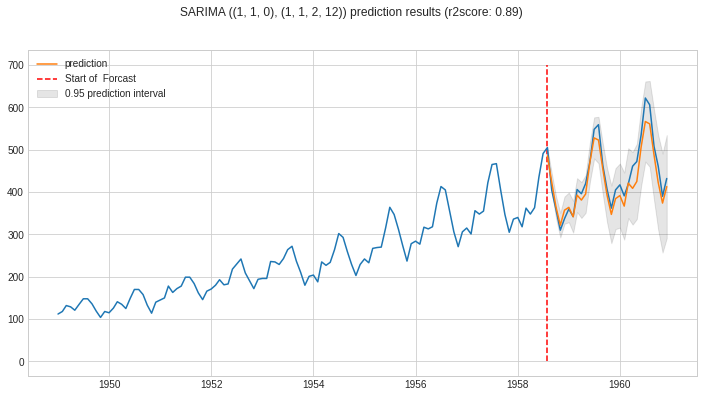

In [55]:
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(data.index, data)
ax.vlines(pd.to_datetime('1958-08-01'), 0,700, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(predict_index, predicted_value, label='prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k',
               alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0], optimal[0][0][1]} prediction results (r2score: {round(r2,2)})')
plt.show()
             